

**Machine Learning I (Semester 1 2024)**
# Tutorial Session 5: Nonlinearity

*N. Hernitschek*



This Jupyter notebook gives an introduction to nonlinear regression techniques.linear regression.

It is based on code from the textbook

*An Introduction to Statistical Learning: with Applications in Python.*
James Witten, Hastie, Tibshirani; Springer.

which is vailable for free as PDF: https://www.statlearning.com/


***Exercises required for class participation are in <font color='red'>red</font>.***

---
## Contents
* [Data Preparation](#first-bullet)
* [Polynomial Regression and Step Functions](#second-bullet)
* [Splines](#third-bullet)
* [Logarithmic and Exponential Regression](#fourth-bullet)





## 1. Data Preparation <a class="anchor" id="first-bullet"></a>

Before we get started with nonlinear regression, we import packages and load data.


### Importing Packages

We start with importing some of our libraries:

In [70]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize, poly, ModelSpec as MS)
from statsmodels.stats.anova import anova_lm


from ISLP.transforms import (BSpline ,
NaturalSpline)
from ISLP.models import bs, ns

%matplotlib inline


### The dataset

The `Wage` dataset is an example data set on which we will do nonlinear regression.

In [71]:
wage = load_data("Wage")
wage.columns


Index(['year', 'age', 'maritl', 'race', 'education', 'region', 'jobclass',
       'health', 'health_ins', 'logwage', 'wage'],
      dtype='object')

In [72]:
wage.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [73]:
y = wage['wage']
age = wage['age']

## 2. Polynomial Regression and Step Functions <a class="anchor" id="second-bullet"></a>

We will use the `poly()` function to create a model matrix that will fit a 4th degree polynomial in `age`.

In [74]:
poly_age = MS([ poly('age', degree =4)]).fit(wage)
M = sm.OLS(y, poly_age.transform(wage)).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


This polynomial is constructed using the function `poly()`, which creates a special transformer `Poly()` (using `sklearn` terminology for feature transformation).
Here `poly()` is referred to as a helper function, and sets up the transformation; `Poly()` is where the transformation is computed.

In the code above, the first line executes the `fit()` method using th dataframe `wage`. This recomputes and stores as attributes any parameters needed by `Poly()` on the training data, and these will be used on all subsequent evaluations of the `transform()` method. 

    

## Making Predictions
We now create a grid of values for age at which we want predictions.








In [76]:
age_grid = np.linspace(age.min(), age.max(), 100)
age_df = pd.DataFrame ({'age': age_grid})

Finally, we wish to plot the data and add the fit from the fourth-degree
polynomial. As we will make several similar plots below, we first write a
function to create all the ingredients and produce the plot. Our function
takes in a model specification (here a basis specified by a transform), as
well as a grid of age values. The function produces a fitted curve as well
as 95% confidence bands. By using an argument for basis we can produce
and plot the results with several different transforms, such as the splines
we will see shortly.

In [77]:
def plot_wage_fit(age_df, basis, title):
  X = basis.transform(wage)
  Xnew = basis.transform(age_df)
  M = sm.OLS(y, X).fit()
  preds = M.get_prediction(Xnew)
  bands = preds.conf_int(alpha =0.05)
  fig , ax = subplots(figsize =(8,8))
  ax.scatter(age, y, facecolor='gray',  alpha =0.5)
  for val, ls in zip([ preds.predicted_mean, bands [:,0], bands [:,1]], ['b','r--','r--']):
    ax.plot(age_df.values , val , ls , linewidth =3)
  ax.set_title(title , fontsize =10)
  ax.set_xlabel('Age', fontsize =10)
  ax.set_ylabel('Wage ', fontsize =10);
  return ax


We include an argument alpha to ax.scatter() to add some transparency
to the points. This provides a visual indication of density. Notice the use
of the zip() function in the for loop above (see Section 2.3.8). We have
three lines to plot, each with different colors and line types. Here zip()
conveniently bundles these together as iterators in the loop.

We now plot the fit of the fourth-degree polynomial using this function.

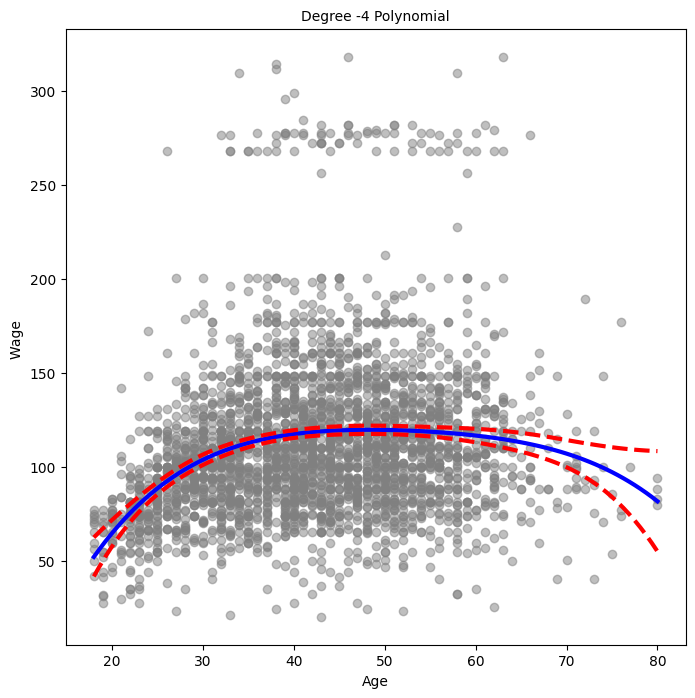

In [78]:
plot_wage_fit(age_df, poly_age, 'Degree -4 Polynomial');

With polynomial regression we must decide on the degree of the polynomial to use. Sometimes we just decide to use second or third degree polynomials, simply to obtain a nonlinear fit. 




<font color='red'>Try this out with different degrees for the polynom.</font>


We can, however, also make such a decision in a more **systematic** way. One way to do this is through **hypothesis tests**. For that, we fit a series of models ranging from linear (degree-one) to degree-five polynomials, and look to determine the simplest model that is sufficient to explain the relationship between wage and age.





### ANOVA Tests for Hypothesis Tests

We use the `anova_lm()` function, which performs a series of
ANOVA tests. An analysis of variance (or ANOVA) tests the null hypothesis
that a model $\mathscr{M}_1$ is sufficient to explain the data against the alternativehypothesis that a more complex model is required. 
The determination is based on an F-test. To perform the test, the models $\mathscr{M}_1$ and $\mathscr{M}_2$ must be nested: the space spanned by the predictors in $\mathscr{M}_1$ must be a subspace of the space spanned by the predictors in $\mathscr{M}_2$. In this case, we fit five different polynomial models and sequentially compare the simpler model to the more complex model.


In [79]:
models = [MS([ poly('age', degree=d)]) for d in range(1, 6)]
Xs = [model.fit_transform(wage) for model in models]
anova_lm (*[sm.OLS(y, X_).fit() for X_ in Xs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.593107,2.363850e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.888756,1.679202e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.809813,5.104620e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.804976,3.696820e-01


Notice the `*` in the `anova_lm()` line above. This function takes a variable
number of non-keyword arguments, in this case fitted models. When these
models are provided as a list (as is done here), it must be prefixed by `*`.

The $p$-value comparing the linear `models[0]` to the quadratic `models[1]` is essentially zero, indicating that a linear fit is not sufficient.

Similarly the $p$-value comparing the quadratic `models[2]` to the cubic `models[3]` is very
low (0.0017), so the quadratic fit is also insufficient. The $p$-value comparing
the cubic and degree-four polynomials, `models[2]` and `models[3]`, is approximately 5%, while the degree-five polynomial `models[4]` seems unnecessary because its $p$-value is 0.37. 

Hence, either a cubic or a quartic polynomial appear to provide a reasonable fit to the data, but lower- or higher-order models are not justified.

In this case, instead of using the `anova()` function, we could have obtained these $p$-values more succinctly by exploiting the fact that `poly()` creates orthogonal polynomials.

In [80]:
summarize(M)

,coef,std err,t,P>|t|
intercept,111.7036,0.729,153.283,0.000
"poly(age, degree=4)[0]",447.0679,39.915,11.201,0.000
"poly(age, degree=4)[1]",-478.3158,39.915,-11.983,0.000
"poly(age, degree=4)[2]",125.5217,39.915,3.145,0.002
"poly(age, degree=4)[3]",-77.9112,39.915,-1.952,0.051


Notice that the $p$-values are the same, and in fact the square of the t-statistics are equal to the F-statistics from the `anova_lm()` function.

However, the ANOVA method works whether or not we used orthogonal polynomials, provided the models are nested. For example, we can use `anova_lm()` to compare the following three models, which all have a linear term in education and a polynomial in age of different degrees:

In [81]:
models = [MS(['education', poly('age', degree=d)]) for d in range(1, 4)]
XEs = [model.fit_transform(wage) for model in models]
anova_lm (*[sm.OLS(y, X_).fit() for X_ in XEs])

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2997.0,3.902335e+06,0.0,NaN,NaN,NaN
1,2996.0,3.759472e+06,1.0,142862.701185,113.991883,3.838075e-26
2,2995.0,3.753546e+06,1.0,5926.207070,4.728593,2.974318e-02


As an alternative to using hypothesis tests and ANOVA, we could choose the polynomial degree using cross-validation.


### Prediction

Next we consider the task of predicting whether an individual earns more than $250,000 per year. We proceed much as before, except that first we create the appropriate response vector, and then apply the `glm()` function
using the binomial family in order to fit a polynomial logistic regression model.





In [82]:
X = poly_age.transform(wage)
high_earn = wage['high_earn '] = y > 250 # shorthand
glm = sm.GLM(y > 250, X, family=sm.families.Binomial())
B = glm.fit()
summarize(B)

,coef,std err,z,P>|z|
intercept,-4.3012,0.345,-12.457,0.000
"poly(age, degree=4)[0]",71.9642,26.133,2.754,0.006
"poly(age, degree=4)[1]",-85.7729,35.929,-2.387,0.017
"poly(age, degree=4)[2]",34.1626,19.697,1.734,0.083
"poly(age, degree=4)[3]",-47.4008,24.105,-1.966,0.049


Once again, we make predictions using the get_prediction() method.

In [36]:
newX = poly_age.transform(age_df)
preds = B.get_prediction(newX)
bands = preds.conf_int(alpha =0.05)

We now plot the estimated relationship.

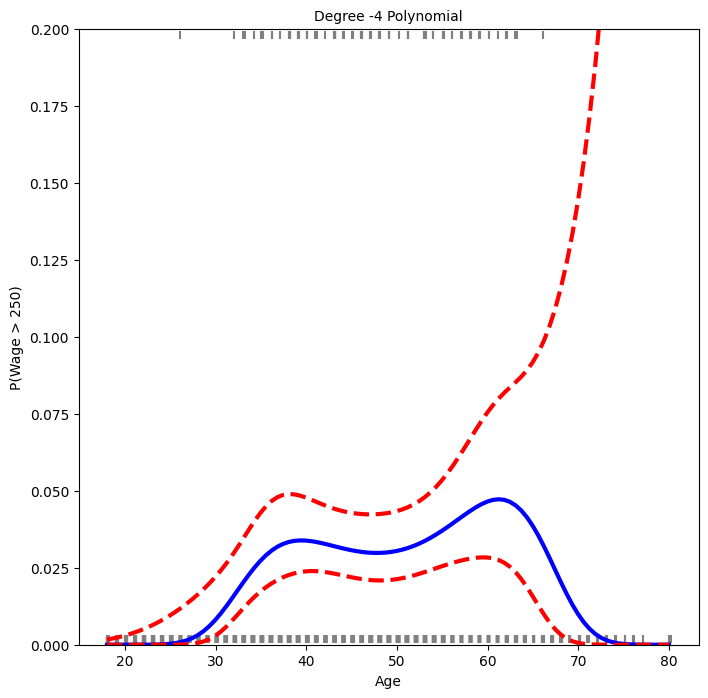

In [83]:
fig , ax = subplots(figsize =(8 ,8))
rng = np.random.default_rng(0)
ax.scatter(age + 0.2 * rng.uniform(size=y.shape [0]), np.where(high_earn, 0.198 , 0.002), fc='gray', marker='|')
for val , ls in zip([ preds.predicted_mean, bands[:,0], bands[:,1]],['b','r--','r--']):
  ax.plot(age_df.values, val, ls, linewidth=3)
ax.set_title('Degree -4 Polynomial', fontsize=10)
ax.set_xlabel('Age', fontsize =10)
ax.set_ylim ([0, 0.2])
ax.set_ylabel('P(Wage > 250)', fontsize =10);

We have drawn the age values corresponding to the observations with `wage` values above 250 as gray marks on the top of the plot, and those with `wage` values below 250 are shown as gray marks on the bottom of the plot.
We added a small amount of noise to jitter the `age?  values a bit so that observations with the same age value do not cover each other up. This type of plot is often called a **rug plot**.

### Fitting a Step Function

In order to fit a step function, we first use the `pd.qcut()` function to discretize age based on quantiles. Then we use `pd.get_dummies()` to create the columns of the model matrix for this categorical variable. Note that this function will include all columns for a given categorical, rather than the usual approach which drops one of the levels.

In [38]:
cut_age = pd.qcut(age , 4)
summarize(sm.OLS(y, pd.get_dummies(cut_age)).fit())


,coef,std err,t,P>|t|
"(17.999, 33.75]",94.1584,1.478,63.692,0.0
"(33.75, 42.0]",116.6608,1.470,79.385,0.0
"(42.0, 51.0]",119.1887,1.416,84.147,0.0
"(51.0, 80.0]",116.5717,1.559,74.751,0.0


Here `pd.qcut()` automatically picked the cutpoints based on the quan-
tiles 25%, 50% and 75%, which results in four regions. We could also have
specified our own quantiles directly instead of the argument. For cuts not based on quantiles we would use the `pd.cut()` function. The function `pd.qcut()` returns an ordered categorical variable. The regression model then creates a set of dummy variables for use in the regression. Since age is the only variable in the model, the value $94,158.40 is the average salary for those under 33.75 years of age, and the other coefficients are the average salary for those in the other age groups. We can produce predictions and plots just as we did in the case of the polynomial fit.

## 3. Splines <a class="anchor" id="third-bullet"></a>

In order to fit regression splines, we use transforms from the ISLP package.
The actual spline evaluation functions are in the `scipy.interpolate` package; we have simply wrapped them as transforms similar to `Poly()`.

The `BSpline()` function generates the entire matrix of basis functions for splines with the specified set of knots. By default, the B-splines produced are cubic. To change the degree, use the argument `degree`.

In [39]:
bs_ = BSpline(internal_knots =[25,40,60], intercept=True).fit(age)
bs_age = bs_.transform(age)
bs_age.shape

(3000, 7)

This results in a seven-column matrix, which is what is expected for a cubic-spline basis with 3 interior knots. We can form this same matrix using the `bs()` object, which facilitates adding this to a model-matrix builder.
We now fit a cubic spline model to the `wage` data.

In [41]:
bs_age = MS([bs('age', internal_knots =[25,40,60])])
Xbs = bs_age.fit_transform(wage)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
"bs(age, internal_knots=[25, 40, 60])[0]",3.9805,12.538,0.317,0.751
"bs(age, internal_knots=[25, 40, 60])[1]",44.6310,9.626,4.636,0.000
"bs(age, internal_knots=[25, 40, 60])[2]",62.8388,10.755,5.843,0.000
"bs(age, internal_knots=[25, 40, 60])[3]",55.9908,10.706,5.230,0.000
"bs(age, internal_knots=[25, 40, 60])[4]",50.6881,14.402,3.520,0.000
"bs(age, internal_knots=[25, 40, 60])[5]",16.6061,19.126,0.868,0.385


The column names are a little cumbersome, and have caused us to truncate the printed summary. They can be set on construction using the `name` argument as follows.

In [42]:
bs_age = MS([bs('age', internal_knots =[25,40,60], name='bs(age)')])
Xbs = bs_age.fit_transform(wage)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,60.4937,9.460,6.394,0.000
bs(age)[0],3.9805,12.538,0.317,0.751
bs(age)[1],44.6310,9.626,4.636,0.000
bs(age)[2],62.8388,10.755,5.843,0.000
bs(age)[3],55.9908,10.706,5.230,0.000
bs(age)[4],50.6881,14.402,3.520,0.000
bs(age)[5],16.6061,19.126,0.868,0.385


Notice that there are 6 spline coefficients rather than 7. This is as by default `bs()` assumes `intercept=False`, since we typically have an overall intercept in the model. So it generates the spline basis with the given knots,
and then discards one of the basis functions to account for the intercept.


We could also use the `df` (degrees of freedom) option to specify the complexity of the spline. We see above that with 3 knots, the spline basis has 6 columns or degrees of freedom. When we specify `df=6` rather than the
actual knots, `bs()` will produce a spline with 3 knots chosen at uniform quantiles of the training data. 

We can see these chosen knots most easily using `Bspline()` directly:

In [43]:
 BSpline(df=6).fit(age).internal_knots_

array([33.75, 42.  , 51.  ])

When asking for six degrees of freedom, the transform chooses knots at ages 33.75, 42.0, and 51.0, which correspond to the 25th, 50th, and 75th
percentiles of age.

When using B-splines we need not limit ourselves to cubic polynomials (i.e. `degree=3`). For instance, using `degree=0` results in piecewise constant functions.

In [45]:
bs_age0 = MS([bs('age', df=3, degree =0)]).fit(wage)
Xbs0 = bs_age0.transform(wage)
summarize(sm.OLS(y, Xbs0).fit())

,coef,std err,t,P>|t|
intercept,94.1584,1.478,63.687,0.0
"bs(age, df=3, degree=0)[0]",22.3490,2.152,10.388,0.0
"bs(age, df=3, degree=0)[1]",24.8076,2.044,12.137,0.0
"bs(age, df=3, degree=0)[2]",22.7814,2.087,10.917,0.0


### Natural Spline

In order to fit a natural spline, we use the `NaturalSpline()` transform with the corresponding helper `ns()`. Here we fit a natural spline with five degrees of freedom (excluding the intercept) and plot the results:

In [46]:
ns_age = MS([ns('age', df=5)]).fit(wage)
M_ns = sm.OLS(y, ns_age.transform(wage)).fit()
summarize(M_ns)

,coef,std err,t,P>|t|
intercept,60.4752,4.708,12.844,0.000
"ns(age, df=5)[0]",61.5267,4.709,13.065,0.000
"ns(age, df=5)[1]",55.6912,5.717,9.741,0.000
"ns(age, df=5)[2]",46.8184,4.948,9.463,0.000
"ns(age, df=5)[3]",83.2036,11.918,6.982,0.000
"ns(age, df=5)[4]",6.8770,9.484,0.725,0.468


We now plot the natural spline using our plotting function.

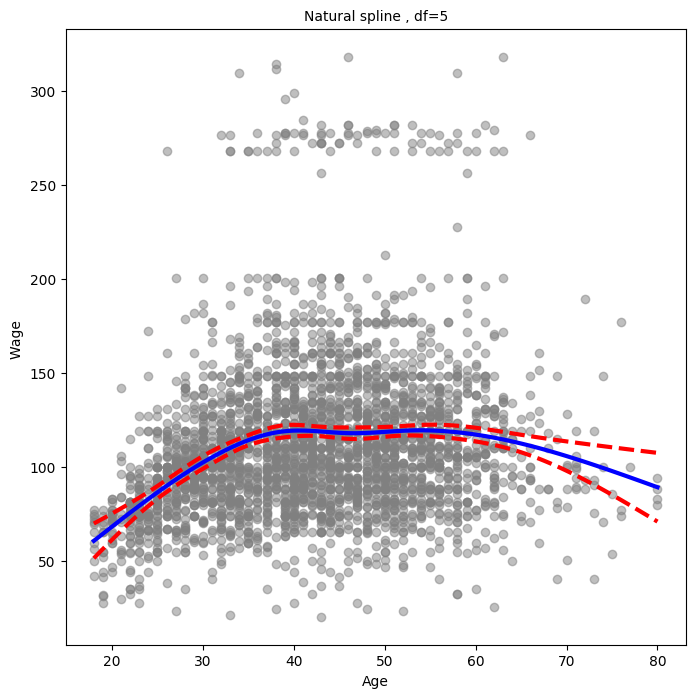

In [84]:
plot_wage_fit(age_df, ns_age, 'Natural spline , df=5');

## 4. Logarithmic and Exponential Regression <a class="anchor" id="fourth-bullet"></a>

First, let's create some fake data for two variables:

In [48]:
import numpy as np
x = np.arange(1, 16, 1)
y = np.array([59, 50, 44, 38, 33, 28, 23, 20, 17, 15, 13, 12, 11, 10, 9.5])



Next, let's create a quick scatterplot to visualize the relationship between `x` and `y`:

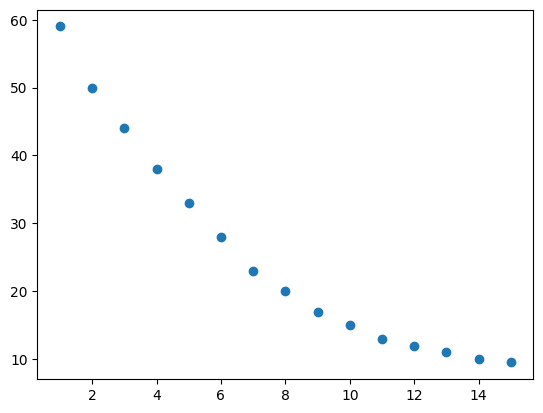

In [50]:
import matplotlib.pyplot as plt

plt.scatter(x, y)
plt.show()

From the plot we can see that there exists a logarithmic decay pattern between the two variables. 
Thus, it seems like a good idea to fit a logarithmic regression equation to describe the relationship between the variables.

We will use the `polyfit()` function to fit a logarithmic regression model, using the natural logarithm of `x` as the predictor variable and `y` as the response variable:

In [62]:
#fit the model
fit = np.polyfit(np.log(x), y, 1)

#view the output of the model
print(fit)


[-20.19869943  63.06859979]


We can use the coefficients  to predict the response variable, `y`, based on the value of the predictor variable, `x`.



In [66]:
xval = 10.0

ypred = fit[1] + fit[0]*np.log(xval)


print(ypred)

16.559375596136277


### Exponential Regression


We can also perform exponential regression

The equation of an exponential regression model takes the following form:

$y = a*b^x$


<font color='red'>Try this out based on the code we have so far.</font>



## Summary <a class="anchor" id="fourth-bullet"></a>

At this point, all of you should have:
* seen how to work with polynomial regression and splines
* seen simple fits within `numpy` for e.g. logarithmic regression.